## Decentralized Multi-agent Pathfinding (MAPF)

In this lab, we will explore the decentralized multi-agent pathfinding problem (decentralized MAPF).

In earlier labs, we focused on various single-agent algorithms. In the previous lab, we tackled the prioritized MAPF problem, where each agent was assigned a unique priority. The trajectories for individual agents were planned sequentially, starting from the highest priority and moving to the lowest. While this approach extended our single-agent algorithms to address more real-world-centered problems, it still imposed certain restrictions on planning. Today, we will delve into a scenario where agents are planned independently, without any specific priority. Each agent considers others as obstacles in their pathfinding process.

We can formally represent this problem as a Markov Decision Process (MDP).

## Markov Decision Process (MDP)

<img src="./img/mdp.png" alt="drawing" width="400"/>

A Markov decision process is a 4-tuple $(S, A, P_a, R_a)$, where:

* $S$ is a set of states called the `state space`,
* $A$ is a set of actions called the `action space` (alternatively, $A_s$ is the set of actions available from state $s$),
* $P_a(s, s') = \Pr(s_{t+1}=s' \mid s_t = s, a_t=a)$ is the probability that action $a$ in state $s$ at time $t$ will lead to state $s'$ at time $t+1$,
* $R_a(s, s')$ is the immediate reward (or expected immediate reward) received after transitioning from state $s$ to state $s'$, due to action $a$


When working with Markov Decision Processes (MDPs), we are interested in finding the optimal policy, denoted as $\pi$. The policy is an abstraction that aids in modeling action selection. Generally, a policy $\pi: A \times S \to [0, 1]$ is a mapping which, at each step $t$, returns the probability of selecting a specific action in a given state, expressed as $\pi(a, s) = P(a_t = a \mid s_t = s)$. The optimality of a policy is typically characterized by the maximization of the sum of discounted rewards: $\pi^* = \arg\max_{\pi} \mathbb{E} [R_{\pi} \mid s_0 = s]$, where $R_{\pi}$ is the discounted (with factor $0 < \gamma < 1$) sum of rewards, represented as $\sum_{t=0}^{T} \gamma^t R_{\arg\max_{a} \pi(a, s_{t-1})} (s_{t-1}, s_t)$, received for actions taken in accordance with policy $\pi$.


To mimic this formalism, we are going to use a powerful [Pogema](https://github.com/AIRI-Institute/pogema/tree/main) library. In the following sections, we will familiarize ourselves with its interface and main features

## Pogema Interface

> POGEMA stands for Partially-Observable Grid Environment for Multiple Agents. It is a grid-based environment that was specifically designed to be flexible, tunable, and scalable. It can be tailored to a variety of PO-MAPF settings. Currently, the somewhat standard setting is supported, in which agents can move between the cardinal-adjacent cells of the grid, and each action (move or wait) takes one time step. No information sharing occurs between the agents. POGEMA can generate random maps and start/goal locations for the agents. It also accepts custom maps as input.

`POGEMA` environment provides a [`Gym`](https://github.com/openai/gym)-like interface where a banch of agents operate in a common environment (grid) and at every step agents choose new actions (moves) based on their observation (neighboring grid cells).

In [24]:
# firstly install pogema and some other necessary libraries.
# it might be required to restart the runtime, please to do so, if mentioned.
# ! conda config --set pip_interop_enabled True
# ! pip3 install pogema ipywidgets joblib tqdm

In [25]:
# import common requirements 
import numpy as np
from copy import copy
from heapq import heappop, heappush

from itertools import product
from joblib import Parallel, delayed

from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import inspect
import os

# import pogema lib and some of the already constucted scenarios, provided by the library
from pogema import pogema_v0
from pogema import Hard8x8
from pogema import GridConfig

# import some utils for animation
from IPython.display import HTML, SVG, display
from pogema.animation import AnimationMonitor, AnimationConfig

### Map Config

Let's examine the built-in methods for one of the default scenarios, `Hard8x8`, which features 4 agents on an 8x8 map.

In [26]:
config = Hard8x8()
help(config)

Help on Hard8x8 in module pogema.grid_config object:

class Hard8x8(PredefinedDifficultyConfig)
 |  Hard8x8(*, MOVES: list = [[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]], FREE: Literal[0] = 0, OBSTACLE: Literal[1] = 1, empty_outside: bool = True, on_target: Literal['finish', 'nothing', 'restart'] = 'finish', seed: int = None, size: Literal[8] = 8, density: float = 0.3, num_agents: Literal[4] = 4, obs_radius: Literal[5] = 5, agents_xy: list = None, targets_xy: list = None, collision_system: Literal['priority'] = 'priority', persistent: bool = False, observation_type: Literal['default'] = 'default', map: Union[list, str] = None, map_name: Literal['Hard8x8'] = 'Hard8x8', integration: Literal['SampleFactory', 'PyMARL', 'rllib', 'gym', 'PettingZoo'] = None, max_episode_steps: Literal[64] = 64, auto_reset: bool = None) -> None
 |  
 |  Method resolution order:
 |      Hard8x8
 |      PredefinedDifficultyConfig
 |      GridConfig
 |      pogema.utils.CommonSettings
 |      pydantic.main.BaseMod

In [27]:

print(f"Seed (used for reproducibility, None by default): {config.seed}")
print(f"Constuct a new config by providing a seed: {Hard8x8(seed=42).seed}")

Seed (used for reproducibility, None by default): None
Constuct a new config by providing a seed: 42


### Environment

`pogema_v0` allows you to pass `grid_config` as an argument to construct an environment



In [28]:
# let's create an instance of Hard8x8 environment with seed=42
env = pogema_v0(grid_config=Hard8x8(seed=42))

Before using our environment, we must reset it

In [29]:
obs, info = env.reset()
# length of `obs` matches the number of agents
len(obs)

4

We could render the current state of the environment

In [30]:
env.render()

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .                                .  .  .  . 
 .  .  .  .        .     .  .              .  .  .  . 
 .  .  .  .     . |2| .     .     .  .     .  .  .  . 
 .  .  .  .     .  .     .     .           .  .  .  . 
 .  .  .  .        .  .  .  .  .           .  .  .  . 
 .  .  .  .    |1| .  . |0| .  .  . |3|    .  .  .  . 
 .  .  .  .     0        .        .  1     .  .  .  . 
 .  .  .  .     .  .  .  .     .           .  .  .  . 
 .  .  .  .     .  .  .  .  2  .  3        .  .  .  . 
 .  .  .  .                                .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 


To proceed to the next state of the environment, we should select actions, one for each agent, and then call `env.step`, which accepts a list of actions, one for each agent.

Our actions are defined as indices in the array `config.MOVES`:
- 0 - wait
- 1 - right
- 2 - left
- 3 - up
- 4 - down


In [31]:
print(f"Possible moves (the action space): {config.MOVES}")

Possible moves (the action space): [[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]]


For example, calling `env.step([3, 2, 1, 0])` would apply the action with index 3 to agent 0, the action with index 2 to agent 1, and so on.

Let's move our agents:

- Agent 0 - up
- Agent 1 - left
- Agent 2 - right
- Agent 3 - wait

In [32]:
# select actions as described above and make sure that the state of the environment changed as expected

# YOUR CODE GOES HERE
# obs, reward, terminated, truncated, info = ...
env.render()

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .                                .  .  .  . 
 .  .  .  .        .     .  .              .  .  .  . 
 .  .  .  .     . |2| .     .     .  .     .  .  .  . 
 .  .  .  .     .  .     .     .           .  .  .  . 
 .  .  .  .        .  .  .  .  .           .  .  .  . 
 .  .  .  .    |1| .  . |0| .  .  . |3|    .  .  .  . 
 .  .  .  .     0        .        .  1     .  .  .  . 
 .  .  .  .     .  .  .  .     .           .  .  .  . 
 .  .  .  .     .  .  .  .  2  .  3        .  .  .  . 
 .  .  .  .                                .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 


### Animation

Instead of rendering our environment every step, we could record an animation using `AnimationMonitor`.

Undertaking actions: [0 3 3 2]
Undertaking actions: [2 4 0 3]
Undertaking actions: [1 0 2 4]
Undertaking actions: [3 3 3 3]
Undertaking actions: [2 0 4 2]
Undertaking actions: [2 1 0 4]
Undertaking actions: [3 3 2 4]
Undertaking actions: [2 2 2 1]
Undertaking actions: [0 2 4 0]
Undertaking actions: [4 4 1 3]


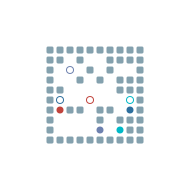

In [33]:
env = pogema_v0(grid_config=Hard8x8(seed=42))
env = AnimationMonitor(
    env
)  # with this line of code we are wrapping our environment so that it can be animated
obs, info = env.reset()
for _ in range(10):
    actions = env.sample_actions()
    print(f"Undertaking actions: {actions}")
    obs, reward, terminated, truncated, info = env.step(actions)
    if all(terminated) or all(truncated):
        break

animation_path = os.path.join("data", "test_animation_default.svg")
env.save_animation(animation_path)  # to save animation, use env.save_animation
display(SVG(animation_path))

In addition, Pogema, by default, considers that all agents have limited observability of the environment. Each agent can only observe a small portion of the map within a fixed `obs_radius`, known as the Field of View (FOV).

`AnimationConfig` enables us to render animations considering this FOV.


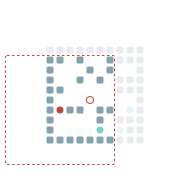

In [34]:
# let's pass AnimationConfig to render animation from the perspective of the agent 0
animation_path = os.path.join("data", "test_animation_egocentric.svg")
env.save_animation(animation_path, AnimationConfig(egocentric_idx=0))
display(SVG(animation_path))

### Custom Config

Pogema allows the creation of custom random maps using `GridConfig`. Passing an instance of `GridConfig` while constructing the environment, as in `pogema_v0(grid_config=GridConfig(...))`, creates a randomly generated map with a fixed density and additional rules specified in GridConfig. A random map is a matrix $N \times N$ with randomly generated obstacles (with probability density). Additionally, Pogema allows the creation of custom maps based on MovingAI environments or even manually specified layouts. However, we will not be focusing on these in this lab.

Below, we present one of the many ways that can be used to specify a MAPF scenario. 


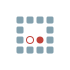

In [35]:
gc = GridConfig(
    num_agents=1,  # locate only single agent on the map
    size=2,  # size of the map
    obs_radius=2,  # radius for the observation of a single agent
    seed=42,
    density=0.0,  # density of obstacles
    max_episode_steps=2,
    on_target="finish",  # let's make our agents disappear after reaching the target
)
env = pogema_v0(grid_config=gc)
env = AnimationMonitor(env)
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step([1])
obs, reward, terminated, truncated, info = env.step([3])
obs, reward, terminated, truncated, info = env.step([0])
obs, reward, terminated, truncated, info = env.step([2])

animation_path = os.path.join("data", "test_custom_animation.svg")
env.save_animation(animation_path)
display(SVG(animation_path))

### Observations

In [36]:
gc = GridConfig(
    num_agents=2,
    size=3,
    obs_radius=2,
    seed=42,
    density=1 / 9,
    max_episode_steps=2,
    on_target="finish",
)
env = pogema_v0(grid_config=gc)
obs, info = env.reset()
env.render()

 .  .  .  .  .  .  . 
 .                 . 
 .     .  .  1     . 
 .     0 |0|       . 
 .     .  . |1|    . 
 .                 . 
 .  .  .  .  .  .  . 


Pogema returns observations in the following format:
1. `obs[k][0]` returns binary mask of obstacles for agent `k` (agent `k` is located in the center of the returned matrix)
2. `obs[k][1]` returns binary mask of agents (agent `k` is located in the center of the returned matrix)
3. `obs[k][2]` returns binary mask for the goal (agent `k` is located in the center of the returned matrix)

In [37]:
obs[1]

array([[[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]]], dtype=float32)

**Question:** What would happen if the goal is outside of the FOV?

## Decentralized MAPF


Consider the following setup:

1. Each agent has limited observability of the environment and can see obstacles and other agents within its Field of View `obs_radius`.
2. At each step, each agent runs a single-agent planning algorithm, treating other agents as obstacles.
Each agent then executes the next planned action and transitions to a new state.
3. Let's leverage our understanding of the `A*` algorithm to create a policy that maps states to actions based on this algorithm.

### Agent, Policy and Implementation details

When working with Markov Decision Processes (MDPs), it is common to abstract a policy $\pi: A \times S \to [0, 1]$ into a class that accepts an observation and outputs the next action in a format expected by our environment (in this case, represented by a Pogema environment). This functionality is usually implemented as an `act` function. Then, to transition into a new state in our environment, we have to call `env.step(policy.act(obs))`

It is also common to model individual agents as classes, encapsulating all the necessary information for a specific actor in our environment. In this lab, each agent is represented as the `AStar` class, storing information about seen obstacles, other agents within the field of view and auxiliary information needed to run the `A*` planning algorithm.

To familiarize ourselves with the most common interfaces, we will need to alter our implementation of the planning algorithms developed in previous labs.


In [38]:
class Node:
    def __init__(self, coord=(float("inf"), float("inf")), g: int = 0, h: int = 0):
        self.i, self.j = coord
        self.g = g
        self.h = h
        self.f = g + h
    
    def __lt__(self, other):
        return self.f < other.f or ((self.f == other.f) and (self.g < other.g))

In [67]:
class AStar:
    def __init__(self):
        """
        Initializes the A* search algorithm.

        Attributes:
        - start: Tuple[int, int], the starting coordinates.
        - goal: Tuple[int, int], the goal coordinates.
        - max_steps: int, the maximum number of steps to search.
        - OPEN: List, the list of open nodes to be explored.
        - CLOSED: Dict, maps coordinates of a node's parent to the node itself.
        - obstacles: Set, the set of obstacle coordinates.
        - other_agents: Set, the set of coordinates occupied by other agents.
        - best_node: Node, the node with the best heuristic value so far.
        """
        self.start = (0, 0)
        self.goal = (0, 0)
        self.max_steps = 10_000
        self.OPEN = list()
        self.CLOSED = (
            dict()
        )  # maps (parent(node).i, parent(node).j) to (node.i, node.j)
        self.obstacles = set()
        self.other_agents = set()
        self.best_node = Node(self.start, 0, self.h(self.start))

    def h(self, node_coord: tuple[int, int]):
        """
        Heuristic function for A* search.

        Args:
        - node_coord: Tuple[int, int], the coordinates of the current node.

        Returns:
        - int, the heuristic value, which is the Manhattan distance to the goal.
        """
        return abs(self.goal[0] - node_coord[0]) + abs(self.goal[1] - node_coord[1])

    def get_neighbors(self, u: Node) -> list[tuple[int, int]]:
        """
        Retrieves the neighbors of a given node that are not obstacles.

        Args:
        - u: Node, the current node.

        Returns:
        - List[Tuple[int, int]], a list of coordinate tuples representing neighbors.
        """
        moves = [(0,0), (1,0), (0,1), (-1,0), (0,-1)]
        return [(u.i+ni, u.j+nj) for (ni,nj) in moves if (u.i+ni, u.j+nj) not in self.obstacles.union(self.other_agents)]

    def _run_astar(self):
        """
        Runs the A* algorithm to find the best path from start to goal.
        Do not return anything, but utilize self.best_node, self.OPEN, self.CLOSED etc. to update the state of the current actor.
        """
        current = Node()
        steps = 0
        while (
            len(self.OPEN) > 0
            and steps < self.max_steps
            and (current.i, current.j) != self.goal
        ):
            steps += 1
            current = heappop(self.OPEN)
            if current.h < self.best_node.h:
                self.best_node = current

            for neighbor_coord in self.get_neighbors(current):
                if neighbor_coord not in self.CLOSED:
                    neighbor = Node(coord=neighbor_coord, g=current.g+1, h=self.h(neighbor_coord))
                    heappush(self.OPEN, neighbor)
                    self.CLOSED[neighbor_coord] = (current.i, current.j)

    def get_next_node(self):
        """
        Retrieves the next node in the path towards the goal using pointers from self.CLOSED.

        Returns:
        - Tuple[int, int], the coordinates of the next node.
        """
        next_node = self.start
        if self.goal in self.CLOSED:
            next_node = self.goal
            while self.CLOSED[next_node] != self.start:
                next_node = self.CLOSED[next_node]  
        return next_node

    def _reset(self):
        """
        Resets the A* search data for a new search.
        """
        self.CLOSED = dict()
        self.OPEN = list()
        heappush(self.OPEN, Node(self.start, 0, self.h(self.start)))
        self.best_node = Node(self.start, 0, self.h(self.start))

    def update_obstacles(self, obs, other_agents):
        """
        Updates the obstacle (self.obstacles) and other agents' positions (self.other_agents).

        Args:
        - obs: ndarray, the obstacle matrix.
        - other_agents: ndarray, the other agents' position matrix.
        """
        obstacles = np.nonzero(obs)
        self.obstacles.clear()
        for x, y in zip(obstacles[0], obstacles[1]):
            self.obstacles.add((x, y))
        self.other_agents.clear()
        agents = np.nonzero(other_agents)
        for x, y in zip(agents[0], agents[1]):
            self.other_agents.add((x, y))

    def update_path(self, start, goal):
        """
        Updates the start and goal positions and runs the A* search.

        Args:
        - start: Tuple[int, int], the new start position.
        - goal: Tuple[int, int], the new goal position.
        """
        self.start = start
        self.goal = goal
        self._reset()
        self._run_astar()

In [40]:
class SimpleAStarPolicy:
    def __init__(self, gc: GridConfig, random_seed=42):
        """
        Initializes the SimpleAStarPolicy class.

        Args:
        - gc: GridConfig, configuration settings for the grid.
        - random_seed: int, the seed for the random number generator.

        Attributes:
        - agents: List, initialized to None, will later store instances of AStar planners.
        - actions: Dict, maps move coordinates to an action ID.
        - obs_radius: int, the radius of observation around an agent.
        - _rnd: RandomState, a random number generator instance.
        """
        self.agents = None
        self.actions = {
            tuple(move): i for i, move in enumerate(gc.MOVES)
        }  # make a dictionary to translate coordinates of actions into their id
        self.obs_radius = gc.obs_radius
        self._rnd = np.random.RandomState(random_seed)

    def _get_goal(self, obs):
        """
        Extracts the goal position from the observation.

        Args:
        - obs: ndarray, the observation matrix.

        Returns:
        - Tuple[int, int], the coordinates of the goal.
        """
        goal = np.nonzero(obs[2])
        goal_i = goal[0][0]
        goal_j = goal[1][0]
        if obs[0][goal_i][goal_j]:
            goal_i -= 1 if goal_i == 0 else 0
            goal_i += 1 if goal_i == self.obs_radius * 2 else 0
            goal_j -= 1 if goal_j == 0 else 0
            goal_j += 1 if goal_j == self.obs_radius * 2 else 0
        return goal_i, goal_j

    def _post_init(self, obs):
        """
        Post-initialization to set up agents.

        Args:
        - obs: ndarray, the observation matrix.
        """
        self.obs_radius = len(obs[0][0]) // 2
        self.agents = [AStar() for _ in obs]  # create a planner for each of the agents

    def compute_action(self, k, single_obs):
        """
        Computes an action for a single observation.

        Args:
        - k: int, the index of the agent.
        - single_obs: ndarray, the observation matrix for a single agent.

        Returns:
        - int, the action to be taken.
        """
        start = (self.obs_radius, self.obs_radius)
        goal = self._get_goal(single_obs)

        if start == goal:  # Agent has reached the goal
            return 0  # Useless action

        # YOUR CODE GOES HERE
        self.agents[k].update_obstacles(obs=single_obs[0], other_agents=single_obs[1])
        self.agents[k].update_path(start, goal) # update path for agent k
        next_node = self.agents[k].get_next_node() # compute next_node

        return self.actions[(next_node[0] - start[0], next_node[1] - start[1])]

    def act(self, obs) -> list[int]:
        """
        Determines actions for all agents based on their observations.

        Args:
        - obs: ndarray, the observation matrix for all agents.

        Returns:
        - List[int], a list of actions for each agent.
        """
        if self.agents is None:
            self._post_init(obs)

        actions = [
            self.compute_action(k, single_obs) for k, single_obs in enumerate(obs)
        ]

        return actions

### Metrics


In MAPF, two common metrics are calculated: Individual Success Rate (ISR) and Collective Success Rate (CSR).

- ISR: The percentage of agents that arrived at their goals. The higher, the better.
- CSR: The percentage of tasks that were fully solved, meaning that each agent successfully reached its corresponding goal. The higher, the better.

Let's take a look at an example of how these metrics are calculated (agents are colored in blue, while the respective targets are colored in yellow. Green indicates that an agent has reached its goal).


<img src="./img/isr_csr.png" alt="metrics" width="800"/>


The Pogema library calculates these metrics for us, returning their values in the last output from `env.step`
`
### Benchmarking

To benchmark our algorithms, let’s leverage the `run_single_policy` and `run_policy` functions.

- `run_single_policy` accepts a class implementing the `.act` function, along with several parameters describing a MAPF scenario (e.g., density and size of the map, number of agents, etc.), and runs an instance of the algorithm on the given map for a fixed number of iterations (`iterations_per_run`). Additionally, this function calculates the most common metrics and, potentially, records animation.

- `run_policy` executes `run_single_policy` multiple times to average the results, ensuring better robustness of the calculated metrics.


In [41]:
def run_single_policy(
    policy_cls,
    num_agents,
    size,
    obs_radius,
    density,
    max_episode_steps,
    base_animation_filename,
    iterations_per_run,
    run_id,
    **kwargs,
):
    """
    Runs a single policy instance over multiple iterations and collects metrics.

    Args:
    - policy_cls: Class, the policy class to be instantiated and evaluated.
    - num_agents: int, number of agents in the environment.
    - size: int, size of the grid environment.
    - obs_radius: int, observation radius for the agents.
    - density: float, obstacle density in the environment.
    - max_episode_steps: int, maximum number of steps in each episode.
    - base_animation_filename: str, base filename for saving animations, if any.
    - iterations_per_run: int, number of iterations to run the policy.
    - run_id: int, an identifier for the current run.
    - **kwargs: additional keyword arguments for the policy class initialization.

    Returns:
    - Tuple[Dict, List]: A tuple containing run metrics and animation file paths.
    """
    run_metrics = defaultdict(list)
    seed = run_id * 2 + 239
    gc = GridConfig(
        num_agents=num_agents,
        size=size,
        obs_radius=obs_radius,
        seed=seed,
        density=density,
        max_episode_steps=max_episode_steps,
        on_target="finish",
    )
    env = pogema_v0(grid_config=gc)
    animation_files = []

    for iteration_id in range(iterations_per_run):
        policy = policy_cls(gc, **kwargs)
        # save only the first animation for each seed
        if base_animation_filename is not None and iteration_id == 0:
            env = AnimationMonitor(env)

        obs, info = env.reset()
        while True:
            obs, reward, terminated, truncated, info = env.step(policy.act(obs))
            if all(terminated) or all(truncated):
                break

        if base_animation_filename is not None and iteration_id == 0:
            save_to_dir = os.path.join("data", f"{num_agents}_{size}_{density}")
            os.makedirs(save_to_dir, exist_ok=True)
            save_to_file = os.path.join(
                save_to_dir, f"{base_animation_filename}_seed{seed}.svg"
            )
            env.save_animation(save_to_file, AnimationConfig(show_lines=True))
            animation_files.append(save_to_file)

        for metric, value in info[0]["metrics"].items():
            run_metrics[metric].append(value)

    return run_metrics, animation_files


def run_policy(
    policy_cls=SimpleAStarPolicy,
    num_agents=10,
    size=8,
    obs_radius=8,
    density=0.0,
    max_episode_steps=256,
    base_animation_filename=None,
    total_runs=100,
    iterations_per_run=10,
    use_status_bar=True,
    **kwargs,
):
    """
    Executes a policy across multiple runs, aggregating metrics and animation files.

    Args:
    - policy_cls: Class, the policy class to be used.
    - num_agents: int, number of agents.
    - size: int, grid size.
    - obs_radius: int, observation radius.
    - density: float, obstacle density.
    - max_episode_steps: int, max steps per episode.
    - base_animation_filename: str, filename for animations.
    - total_runs: int, number of total runs to execute.
    - iterations_per_run: int, iterations per run.
    - use_status_bar: bool, show status bar during execution
    - **kwargs: additional keyword arguments for the policy class.

    Returns:
    - Tuple[Dict, List]: A tuple containing aggregated metrics and animation file paths from all runs.
    """
    all_metrics = defaultdict(list)
    all_animation_files = []

    results = []
    run_range = None
    if use_status_bar:
        run_range = tqdm(range(total_runs))
    else:
        run_range = range(total_runs)
    for run_id in run_range:
        res = run_single_policy(
            policy_cls,
            num_agents,
            size,
            obs_radius,
            density,
            max_episode_steps,
            base_animation_filename,
            iterations_per_run,
            run_id,
        )
        results.append(res)

    for metrics, animation_files in results:
        for metric, value in metrics.items():
            all_metrics[metric].extend(value)
        all_animation_files.extend(animation_files)

    return all_metrics, all_animation_files

In [42]:
metrics, files = run_policy(
    SimpleAStarPolicy, base_animation_filename="render", total_runs=100, iterations_per_run=1, use_status_bar=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
for metric in ["ISR", "CSR"]:
    print(f"{metric}: {np.mean(metrics[metric]) * 100}%")

ISR: 98.4%
CSR: 93.0%


Although the `A*` algorithm is fully capable of finding a solution, there are instances where it may produce a cycle, trapping the agents within it. Let's compare the following two task instances:

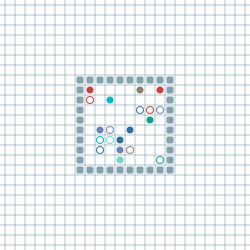

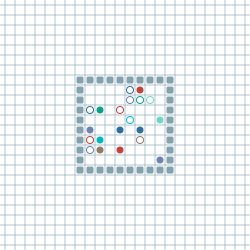

In [44]:
display(SVG(files[0]))
display(SVG(files[7]))

As can be seen, the second instance does not finish; the agents are stuck in an infinite loop. This occurs due to the deterministic nature of our MDP-style solution: every two steps, these remaining agents end up with the same observations as they had two steps before, compute the same actions, and thus enter the loop.

To address this issue, let's add support for conflict resolution:

1. With a fixed probability $\varepsilon$ ($epsilon$), choose a random action at each step - known as the **$\varepsilon$-greedy policy**.
2. For each agent, store the last $N$ positions. If the agent returns to one of these $N$ positions, choose a random action - this is the **history-based policy**.


### $\varepsilon$-greedy Policy

In [52]:
class EpsGreedyPolicy(SimpleAStarPolicy):
    def __init__(self, gc: GridConfig, random_seed=42, eps: float = 0.2):
        """
        Initializes the EpsGreedyPolicy class, which is an extension of the SimpleAStarPolicy class
        with an epsilon-greedy strategy for action selection.

        Args:
        - gc: GridConfig, configuration settings for the grid.
        - random_seed: int, the seed for the random number generator.
        - eps: float, the probability of choosing a random action (exploration factor).

        Attributes:
        - _eps: float, the epsilon value for the epsilon-greedy strategy.
        """
        super().__init__(gc, random_seed)
        self._eps = eps

    def _randomly_update_actions(self, actions):
        """
        Randomly updates actions based on the epsilon value. With a probability of epsilon,
        an action is replaced with a random action.

        Args:
        - actions: List[int], a list of actions chosen by the base policy.

        Modifies:
        - actions: List[int], with some actions potentially replaced randomly.
        """
        for idx, _ in enumerate(actions):
            if self._rnd.random() < self._eps:
                actions[idx] = self._rnd.randint(1, len(self.actions) - 1)

    def act(self, obs):
        """
        Overrides the act method from the SimpleAStarPolicy class to include epsilon-greedy behavior.

        Args:
        - obs: ndarray, the observation matrix for all agents.

        Returns:
        - List[int], a list of actions for each agent, with some actions potentially chosen randomly.
        """
        actions = super().act(obs)  # Get actions from the base policy
        self._randomly_update_actions(actions)  # Randomly alter some actions
        return actions

In [53]:
metrics, files = run_policy(
    EpsGreedyPolicy,
    base_animation_filename="render",
    eps=0.0,
    total_runs=10,
    iterations_per_run=1,
    use_status_bar=True
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
for metric in ["ISR", "CSR"]:
    print(f"{metric}: {np.mean(metrics[metric]) * 100}%")

ISR: 100.0%
CSR: 100.0%


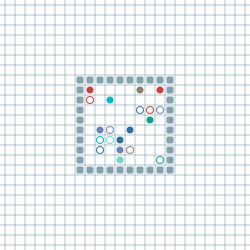

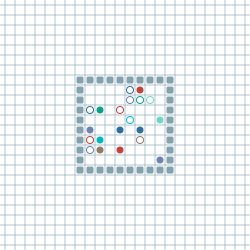

In [55]:
display(SVG(files[0]))
display(SVG(files[7]))

**Your observations here:**

### History-based Policy


In [57]:
class HistoryBasedPolicy(SimpleAStarPolicy):
    def __init__(self, gc: GridConfig, random_seed=42, history_len: int = 3):
        """
        Initializes the HistoryBasedPolicy class, extending the SimpleAStarPolicy class with
        a history-based decision-making approach.

        Args:
        - gc: GridConfig, configuration settings for the grid.
        - random_seed: int, the seed for the random number generator.
        - history_len: int, the length of the observation history to maintain for each agent.

        Attributes:
        - _history: List[List[ndarray]], a list to store the history of observations for each agent.
        - _history_ptr: int, a pointer to manage the circular history buffer.
        - _max_history_len: int, the maximum length of the history.
        """
        super().__init__(gc, random_seed)
        self._history = None
        self._history_ptr = 0  # Pointer to the current position in the history buffer
        self._max_history_len = history_len

    def _post_init(self, obs):
        """
        Post-initialization to set up history buffers for agents.

        Args:
        - obs: ndarray, the observation matrix.
        """
        super()._post_init(obs)
        total_agents = len(self.agents)
        self._history = [[] for _ in range(total_agents)]

    def _update_history(self, obs):
        """
        Updates the history of observations for each agent, treating the history as a circular buffer.

        This method ensures that each agent's history of observations is kept up to date. The history is
        managed as a circular buffer: when the buffer reaches its maximum capacity (_max_history_len), new
        observations overwrite the oldest ones. This approach is efficient for memory usage and quick updates.

        Args:
        - obs: ndarray, the current set of observations for all agents.
        """
        for agent_history, cur_obs in zip(self._history, obs):
            if len(agent_history) < self._max_history_len:
                agent_history.append(cur_obs)
            else:
                agent_history[self._history_ptr] = cur_obs
        self._history_ptr = (self._history_ptr + 1) % self._max_history_len

    def act(self, obs):
        """
        Overrides the act method to incorporate history-based action selection.

        Args:
        - obs: ndarray, the current set of observations for all agents.

        Returns:
        - List[int], a list of actions for each agent, potentially influenced by their observation history.
        """
        actions = super().act(obs)
        new_actions = copy(actions)
        for agent_id, agent_obs in enumerate(obs):
            for h in self._history[agent_id]:
                if np.all(h == agent_obs):
                    new_actions[agent_id] = self._rnd.randint(1, len(self.actions) - 1)
        self._update_history(obs)
        return new_actions

In [58]:
metrics, files = run_policy(
    HistoryBasedPolicy,
    base_animation_filename="render",
    total_runs=100,
    iterations_per_run=3,
    history_len=3,
    use_status_bar=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
for metric in ["ISR", "CSR"]:
    print(f"{metric}: {np.mean(metrics[metric]) * 100}%")

ISR: 100.0%
CSR: 100.0%


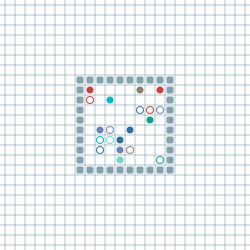

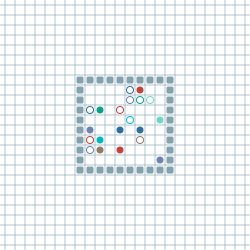

In [60]:
display(SVG(files[0]))
display(SVG(files[7]))

**Your observations here:**

## Experiments

To compare three conflict resolution techniques: `SimpleAStarPolicy` (which involves no resolution), `EpsGreedyPolicy` (undertaking a random action with a fixed probability), and `HistoryBasedPolicy` (storing the last N positions), let's create maps with varying system configurations.


In [61]:
CONFIGURATIONS = [
    {"num_agents": 10, "size": 8, "density": 0.0, "total_runs": 100},
    {"num_agents": 20, "size": 8, "density": 0.0, "total_runs": 100},
    {"num_agents": 30, "size": 8, "density": 0.0, "total_runs": 100},
    {"num_agents": 10, "size": 8, "density": 0.1, "total_runs": 100},
    {"num_agents": 20, "size": 8, "density": 0.1, "total_runs": 100},
    {"num_agents": 10, "size": 8, "density": 0.2, "total_runs": 100},
    {"num_agents": 30, "size": 16, "density": 0.0, "total_runs": 5},
    {"num_agents": 30, "size": 16, "density": 0.2, "total_runs": 5},
    {"num_agents": 30, "size": 16, "density": 0.4, "total_runs": 5},
]

POLICIES = [
    {"policy_cls": SimpleAStarPolicy},
    {"policy_cls": EpsGreedyPolicy, "eps": 0.2},
    {"policy_cls": HistoryBasedPolicy, "history_len": 2},
]

In [62]:
# helper functions and variables to better display the results of the experiment
def key(d):
    return "_".join(
        f"{k}={v if not inspect.isclass(v) else v.__name__}" for k, v in d.items()
    )


config_keys = [key(config) for config in CONFIGURATIONS]
policy_keys = [key(policy) for policy in POLICIES]

dataframes = defaultdict(lambda: pd.DataFrame(index=config_keys, columns=policy_keys))

In [63]:
config_policy_pairs = list(product(CONFIGURATIONS, POLICIES))
print(f"Total configurations: {len(config_policy_pairs)}")
print(f"Example of a single configuration: {config_policy_pairs[0]}")

Total configurations: 27
Example of a single configuration: ({'num_agents': 10, 'size': 8, 'density': 0.0, 'total_runs': 100}, {'policy_cls': <class '__main__.SimpleAStarPolicy'>})


In [64]:
def process_config_policy_pair(configuration, policy):
    """
    Processes a given configuration and policy pair by running the policy and computing average metrics.

    This function runs the specified policy with the given configuration, collects the metrics,
    and processes these metrics to compute their mean values. It also prints a message upon completion
    of processing each pair.

    Args:
    - configuration: dict, the configuration settings for the run.
    - policy: dict, the policy settings to be applied.

    Returns:
    - dict, processed data containing the mean values of metrics for the given configuration and policy.
    """
    metrics, files = run_policy(iterations_per_run=3, use_status_bar=False, **configuration, **policy)
    processed_data = {}
    for metric in metrics:
        processed_data[(key(configuration), key(policy), metric)] = np.mean(metrics[metric])
    print(f"Processed: {key(configuration)}, {key(policy)}")
    return processed_data

When working with a large number of configuration and policy combinations, processing each pair sequentially can be very time-consuming. Parallelization allows multiple pairs to be processed simultaneously, significantly reducing the overall computation time.

In [66]:
# call `process_config_policy_pair` for each pair from `config_policy_pairs` in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_config_policy_pair)(*pair) for pair in config_policy_pairs
)

for result in results:
    for (config_key, policy_key, metric_key), value in result.items():
        dataframes[metric_key].loc[config_key, policy_key] = value * 100

Processed: num_agents=10_size=8_density=0.0_total_runs=100, policy_cls=HistoryBasedPolicy_history_len=2
Processed: num_agents=10_size=8_density=0.0_total_runs=100, policy_cls=EpsGreedyPolicy_eps=0.2
Processed: num_agents=10_size=8_density=0.0_total_runs=100, policy_cls=SimpleAStarPolicy
Processed: num_agents=10_size=8_density=0.1_total_runs=100, policy_cls=EpsGreedyPolicy_eps=0.2
Processed: num_agents=20_size=8_density=0.0_total_runs=100, policy_cls=HistoryBasedPolicy_history_len=2
Processed: num_agents=10_size=8_density=0.1_total_runs=100, policy_cls=SimpleAStarPolicy
Processed: num_agents=20_size=8_density=0.0_total_runs=100, policy_cls=EpsGreedyPolicy_eps=0.2
Processed: num_agents=10_size=8_density=0.1_total_runs=100, policy_cls=HistoryBasedPolicy_history_len=2
Processed: num_agents=20_size=8_density=0.1_total_runs=100, policy_cls=HistoryBasedPolicy_history_len=2
Processed: num_agents=20_size=8_density=0.1_total_runs=100, policy_cls=EpsGreedyPolicy_eps=0.2
Processed: num_agents=30_s

In [68]:
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: cadetblue; color: white; font-weight: bold;" if v else "" for v in is_max]

for metric in dataframes:
    if metric in ("ISR", "CSR"):
        display(HTML(f"<h3>{metric}</h3>"))
        display(dataframes[metric].style.apply(highlight_max, axis=1))

,policy_cls=SimpleAStarPolicy,policy_cls=EpsGreedyPolicy_eps=0.2,policy_cls=HistoryBasedPolicy_history_len=2
num_agents=10_size=8_density=0.0_total_runs=100,98.400000,100.000000,100.000000
num_agents=20_size=8_density=0.0_total_runs=100,95.250000,100.000000,100.000000
num_agents=30_size=8_density=0.0_total_runs=100,91.400000,100.000000,100.000000
num_agents=10_size=8_density=0.1_total_runs=100,96.200000,100.000000,100.000000
num_agents=20_size=8_density=0.1_total_runs=100,90.600000,100.000000,100.000000
num_agents=10_size=8_density=0.2_total_runs=100,90.300000,100.000000,100.000000
num_agents=30_size=16_density=0.0_total_runs=5,100.000000,100.000000,100.000000
num_agents=30_size=16_density=0.2_total_runs=5,98.666667,100.000000,100.000000
num_agents=30_size=16_density=0.4_total_runs=5,44.666667,78.000000,83.333333


,policy_cls=SimpleAStarPolicy,policy_cls=EpsGreedyPolicy_eps=0.2,policy_cls=HistoryBasedPolicy_history_len=2
num_agents=10_size=8_density=0.0_total_runs=100,93.000000,100.000000,100.000000
num_agents=20_size=8_density=0.0_total_runs=100,64.000000,100.000000,100.000000
num_agents=30_size=8_density=0.0_total_runs=100,41.000000,100.000000,100.000000
num_agents=10_size=8_density=0.1_total_runs=100,87.000000,100.000000,100.000000
num_agents=20_size=8_density=0.1_total_runs=100,63.000000,100.000000,100.000000
num_agents=10_size=8_density=0.2_total_runs=100,73.000000,100.000000,100.000000
num_agents=30_size=16_density=0.0_total_runs=5,100.000000,100.000000,100.000000
num_agents=30_size=16_density=0.2_total_runs=5,80.000000,100.000000,100.000000
num_agents=30_size=16_density=0.4_total_runs=5,0.000000,40.000000,20.000000


### Analyze the Results
As expected, SimpleAStarPolicy is the slowest